# Лабораторная работа 5. Деревья решений.
## Нечетный вариант - оценки студентов.
## Раевский Григорий Романович, P3321


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("data.csv", delimiter=',')
data

,STUDENT ID,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,COURSE ID,GRADE
0,STUDENT1,2,2,3,3,1,2,2,1,1,...,1,1,3,2,1,2,1,1,1,1
1,STUDENT2,2,2,3,3,1,2,2,1,1,...,1,1,3,2,3,2,2,3,1,1
2,STUDENT3,2,2,2,3,2,2,2,2,4,...,1,1,2,2,1,1,2,2,1,1
3,STUDENT4,1,1,1,3,1,2,1,2,1,...,1,2,3,2,2,1,3,2,1,1
4,STUDENT5,2,2,1,3,2,2,1,3,1,...,2,1,2,2,2,1,2,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,STUDENT141,2,1,2,3,1,1,2,1,1,...,1,1,2,1,2,1,3,3,9,5
141,STUDENT142,1,1,2,4,2,2,2,1,4,...,1,1,3,2,2,1,5,3,9,5
142,STUDENT143,1,1,1,4,2,2,2,1,1,...,1,1,3,3,2,1,4,3,9,1
143,STUDENT144,2,1,2,4,1,1,1,5,2,...,2,1,2,1,2,1,5,3,9,4


### Метрика

In [3]:
data['STATUS'] = data['GRADE'].apply(lambda x: 1 if x >= 3 else 0)
data

,STUDENT ID,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,COURSE ID,GRADE,STATUS
0,STUDENT1,2,2,3,3,1,2,2,1,1,...,1,3,2,1,2,1,1,1,1,0
1,STUDENT2,2,2,3,3,1,2,2,1,1,...,1,3,2,3,2,2,3,1,1,0
2,STUDENT3,2,2,2,3,2,2,2,2,4,...,1,2,2,1,1,2,2,1,1,0
3,STUDENT4,1,1,1,3,1,2,1,2,1,...,2,3,2,2,1,3,2,1,1,0
4,STUDENT5,2,2,1,3,2,2,1,3,1,...,1,2,2,2,1,2,2,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,STUDENT141,2,1,2,3,1,1,2,1,1,...,1,2,1,2,1,3,3,9,5,1
141,STUDENT142,1,1,2,4,2,2,2,1,4,...,1,3,2,2,1,5,3,9,5,1
142,STUDENT143,1,1,1,4,2,2,2,1,1,...,1,3,3,2,1,4,3,9,1,0
143,STUDENT144,2,1,2,4,1,1,1,5,2,...,1,2,1,2,1,5,3,9,4,1


### Отбор признаков

In [4]:
import random
import math

feature_columns = [col for col in data.columns if col not in ['STUDENT ID', 'GRADE', 'STATUS']]

n_features = len(feature_columns)
squared = math.ceil(np.sqrt(n_features))

selected = np.random.choice(feature_columns, squared, replace=False)

selected_data = data[selected]
selected_data


,1,21,2,15,16,9
0,2,1,2,2,5,1
1,2,1,2,2,1,1
2,2,1,2,2,1,4
3,1,1,1,2,1,1
4,2,1,2,2,4,1
...,...,...,...,...,...,...
140,2,1,1,2,4,1
141,1,1,1,2,1,4
142,1,1,1,2,4,1
143,2,1,1,3,3,2


### Реализация дерева

In [5]:
from dataclasses import dataclass
from typing import Optional


@dataclass
class Node:
    feature: Optional[int] = None  
    threshold: Optional[float] = None  
    left: Optional['Node'] = None  
    right: Optional['Node'] = None
    value: Optional[int] = None

In [6]:
class Tree:
    def __init__(self, min_split=2, max_depth=100):
        self.min_split = min_split
        self.max_depth = max_depth
        self.root = None
    
    def gini(self, y):
        ratio = np.bincount(y) / len(y)
        return 1 - np.sum(ratio**2)
    
    def split(self, X, y, feature, threshold):
        l = X[:, feature] < threshold
        r = X[:, feature] >= threshold
        return X[l], X[r], y[l], y[r]
    
    def best_split(self, X, y):
        best_gini = float('inf')
        best_feature = None
        best_threshold= None

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])

            for threshold in thresholds:
                X_l, X_r, y_l, y_r = self.split(X,y, feature, threshold)
                if len(y_r) == 0 or len(y_l) == 0:
                    continue

                gini_l = self.gini(y_l)
                gini_r = self.gini(y_r)
                res_gini = (len(y_r)/len(y))*gini_l + (len(y_l)/len(y))*gini_r 

                if res_gini < best_gini:
                    best_gini = res_gini
                    best_feature = feature
                    best_threshold = threshold
        return best_feature, best_threshold
    
    def majority_class(self, y):
        return np.bincount(y).argmax()
    
    def build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))

        if n_classes == 1 or n_samples < self.min_split or depth >= self.max_depth:
            leaf_value = self.majority_class(y)
            return Node(value=leaf_value)
        
        best_feature, best_threshold= self.best_split(X,y)

        if best_feature is None:
            leaf_value = self.majority_class(y)
            return Node(value=leaf_value)
        
        X_l, X_r, y_l, y_r = self.split(X, y, best_feature, best_threshold)

        l_node = self.build_tree(X_l, y_l, depth+1)
        r_node = self.build_tree(X_r,y_r,depth+1)

        return Node(best_feature, best_threshold, l_node, r_node)
    
    def fit(self, X, y):
        self.root = self.build_tree(X,y)
    
    def predict_sample(self, node, sample):
        if node.value is not None:
            return node.value
        
        if sample[node.feature] < node.threshold:
            return self.predict_sample(node.left, sample)
        else:
            return self.predict_sample(node.right, sample)
        
    def predict(self, X):
        return [self.predict_sample(self.root, sample) for sample in X]

### Оценка алгоритма

Accuracy

In [7]:
def accuracy(y_true, y_pred):
    return (np.sum (y_true == y_pred) / len(y_true))

Precision

In [8]:
def precision(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum ((y_true == 0) & (y_pred == 1))

    if tp+fp == 0:
        return 0
    return tp / (tp+fp)

Recall

In [9]:
def recall(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    if tp + fn == 0:
        return 0
    return tp / (tp + fn)

Разделение выборки

In [10]:
def train_test_split(X, y, test_size=0.2):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    test_count = int(test_size * X.shape[0])
    test_indices = indices[:test_count]
    train_indices = indices[test_count:]
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

X = data[selected].values
y = data['STATUS'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Оценка модели

In [11]:

tree = Tree(max_depth=8)
tree.fit(X_train, y_train)

predictions = np.array(tree.predict(X_test))  

acc = accuracy(y_test, predictions)
prec = precision(y_test, predictions)
rec = recall(y_test, predictions)

print(f"Accuracy: {acc:.2f}")
print(f"Precision: {prec:.2f}")
print(f"Recall: {rec:.2f}")


Accuracy: 0.51
Precision: 0.64
Recall: 0.36


### Кривые AUC-ROC и AUC-PR 

Построение ROC кривой

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def roc_curve(y_true, y_scores):
    thresholds = np.sort(np.unique(y_scores))[::-1]
    
    tpr = []
    fpr = []
    
    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)
        
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        tn = np.sum((y_true == 0) & (y_pred == 0))
        
        tpr.append(tp / (tp + fn) if (tp + fn) != 0 else 0)
        fpr.append(fp / (fp + tn) if (fp + tn) != 0 else 0)
    
    return fpr, tpr, thresholds


Расчет AUC_ROC

In [13]:
def auc_roc(fpr, tpr):
    return np.trapz(tpr, fpr)

Построение PR кривой

In [14]:
def precision_recall_curve(y_true, y_scores):
    thresholds = np.sort(np.unique(y_scores))[::-1]
    
    precisions = []
    recalls = []
    
    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)
        
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        
        precision = tp / (tp + fp) if (tp + fp) != 0 else 0
        recall = tp / (tp + fn) if (tp + fn) != 0 else 0
        
        precisions.append(precision)
        recalls.append(recall)
    
    return precisions, recalls, thresholds

Расчет AUR_PR

In [15]:
def auc_pr(precisions, recalls):
    return np.trapz(precisions, recalls)

Построение графиков

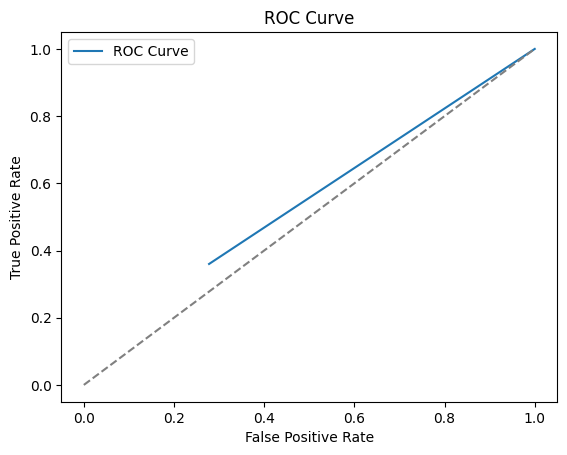

AUC-ROC: 0.49


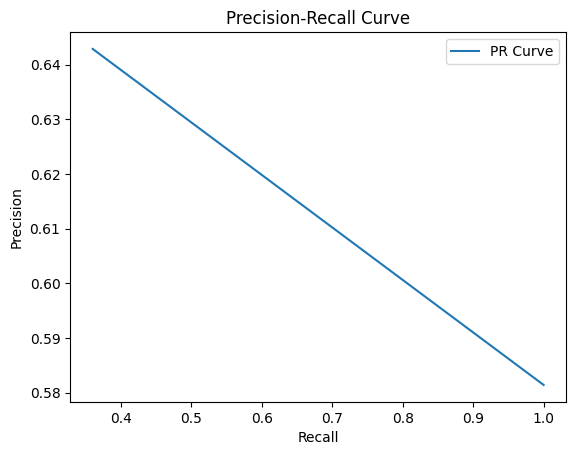

AUC-PR: 0.39


In [16]:
fpr, tpr, thresholds = roc_curve(y_test, predictions)
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

roc_auc = auc_roc(fpr, tpr)
print(f"AUC-ROC: {roc_auc:.2f}")

precisions, recalls, thresholds = precision_recall_curve(y_test, predictions)
plt.plot(recalls, precisions, label="PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

pr_auc = auc_pr(precisions, recalls)
print(f"AUC-PR: {pr_auc:.2f}")